# 猫狗大战

## 准备工作

导入所需的库

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from tqdm import tqdm
import pickle

from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# import torch
# from torch import nn
# from torch import optim
# import torch.nn.functional as F
# from torch.autograd import Variable
# from torchvision import datasets, transforms, models

## 数据观察与预处理

先列出训练数据集`train`文件夹下的所有文件名。

In [4]:
data_dir = './{}/'
files = {}
for i in ['train', 'test']:
    files[i] = []
    for dirpath, dirname, filename in os.walk(data_dir.format(i)):
        files[i].extend(filename)

### 随机抽取部分样本进行观察。

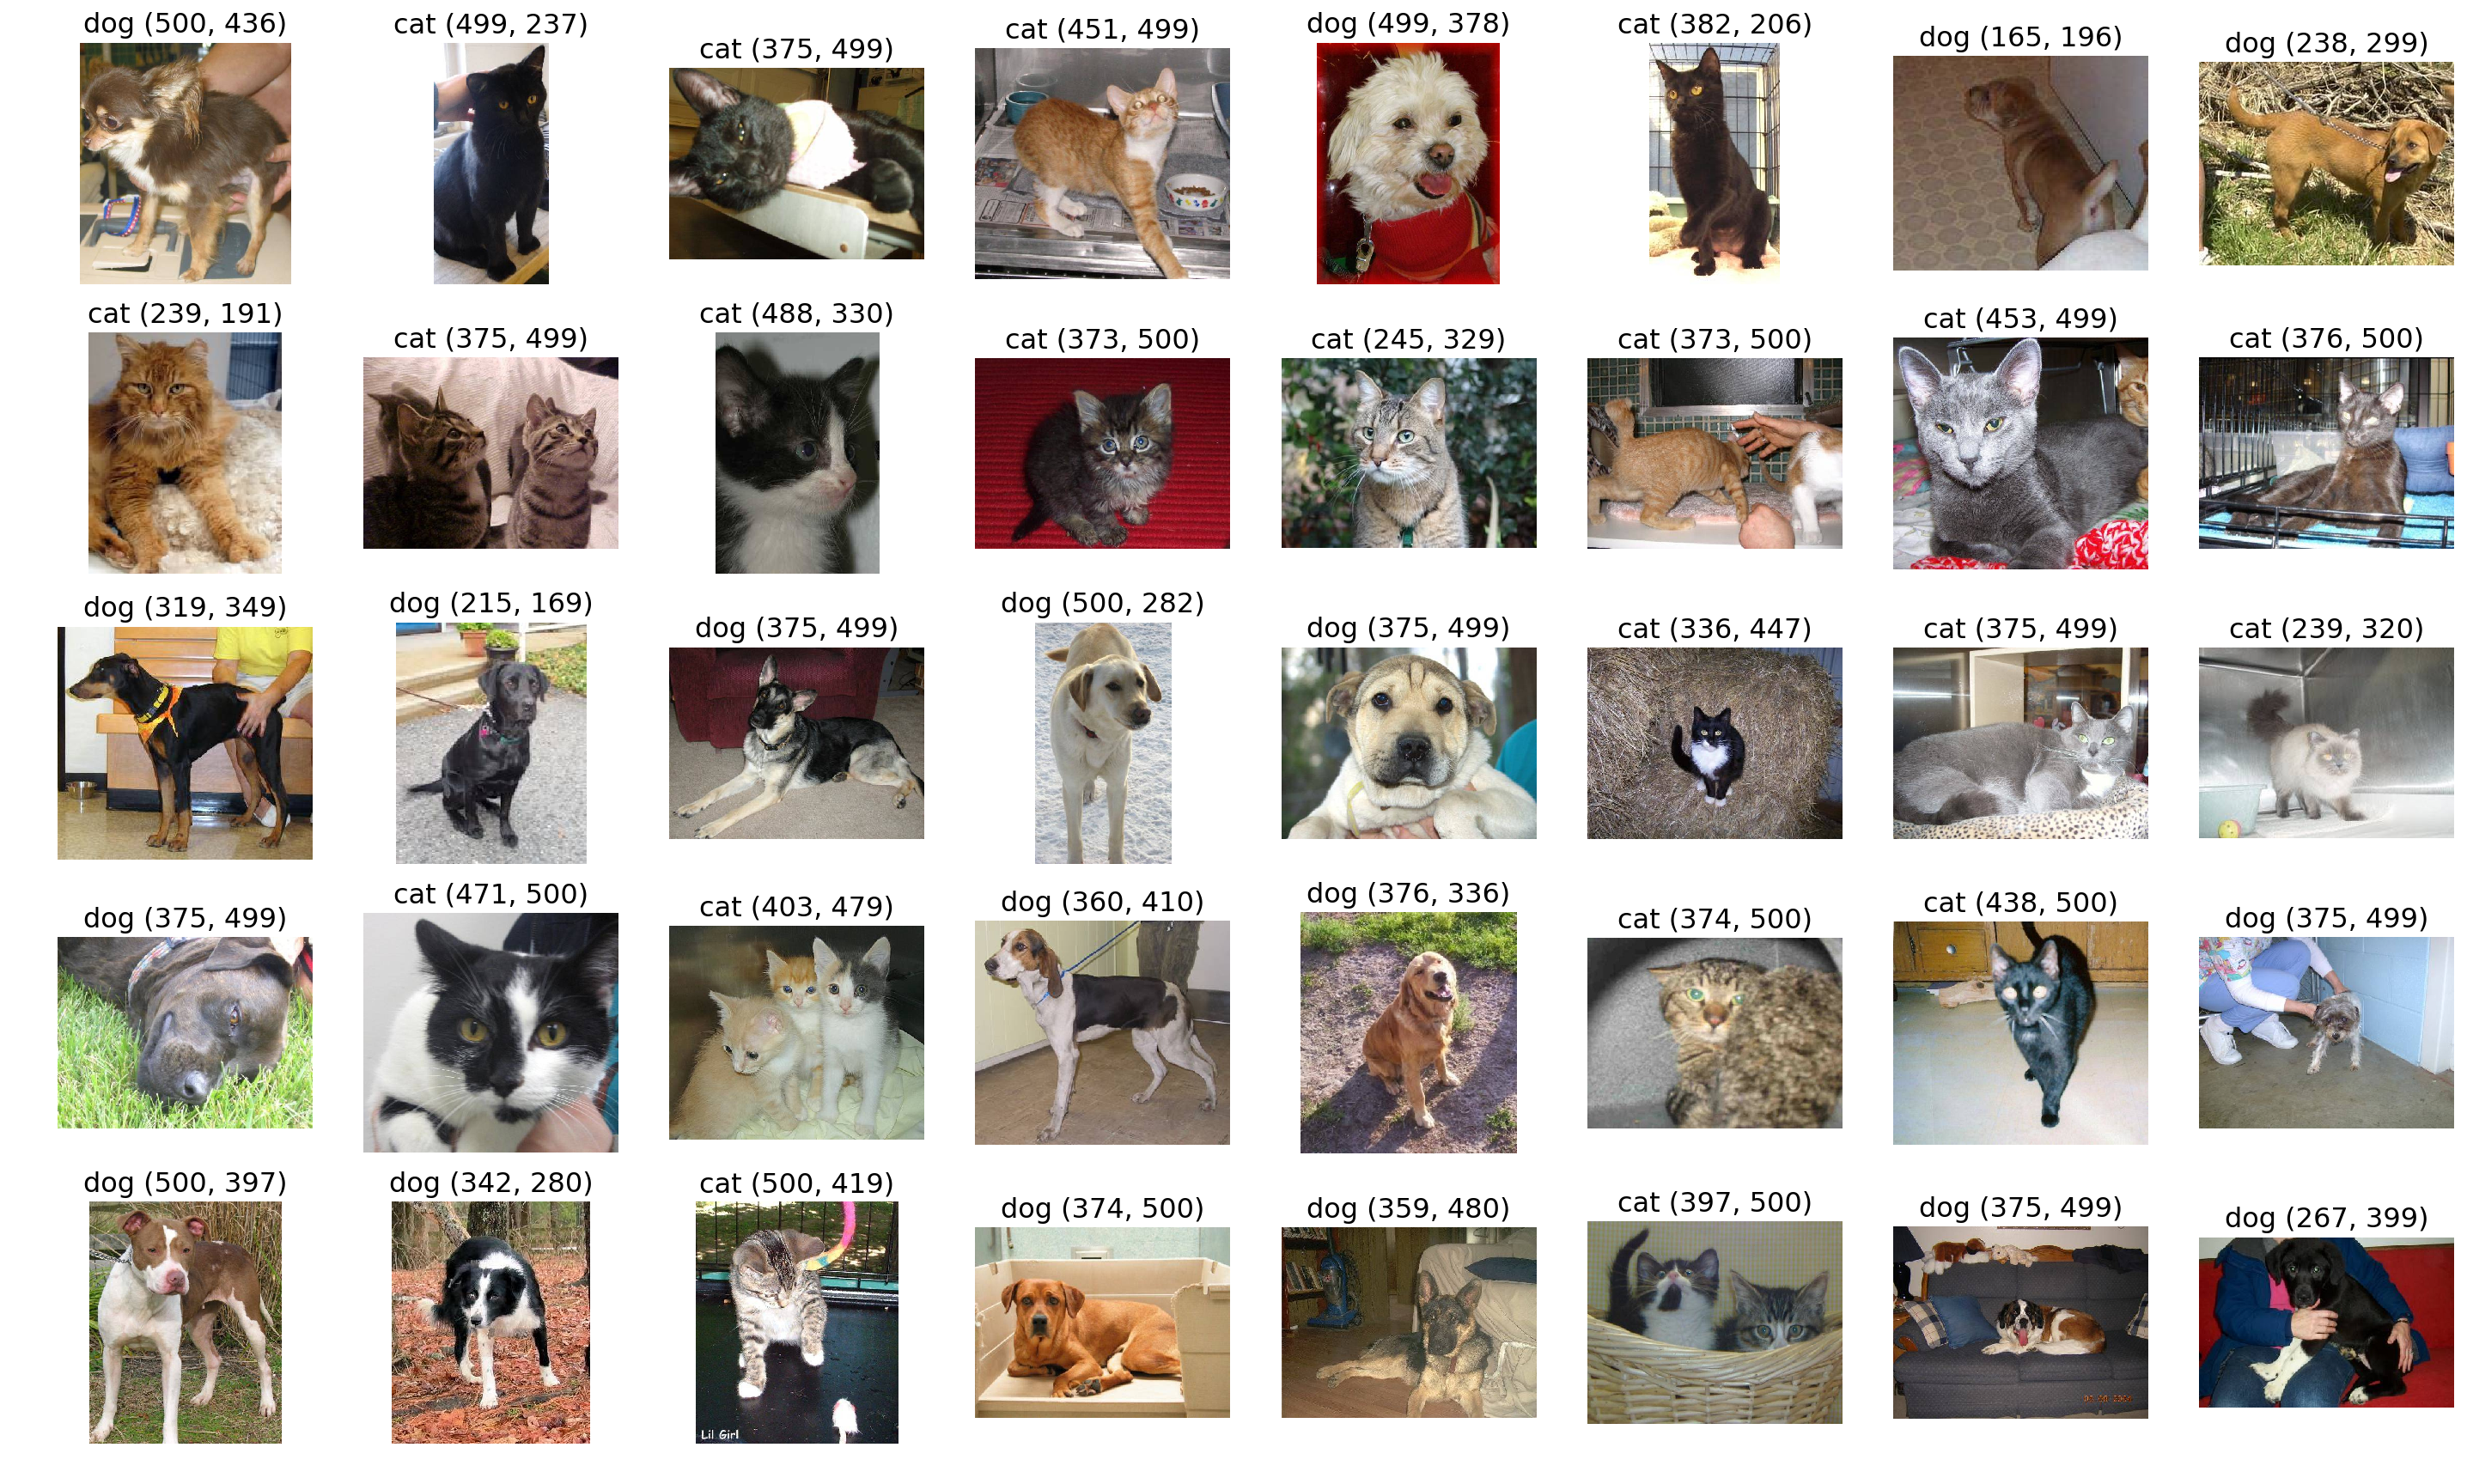

In [7]:
plt.figure(figsize=[25, 15])
random.seed(1234)
sample_size = 40
samples = random.sample(files['train'], sample_size)
labels = [x.split('.')[0] for x in samples]
for i in range(1, sample_size+1):
    plt.subplot(5, 8, i)
    tester = mpimg.imread(data_dir.format('train')+samples[i-1])
    img_shape = tester.shape[:2]
    plt.imshow(tester)
    plt.axis('off')
    plt.title(labels[i-1]+' '+str(img_shape), fontdict={'fontsize':16})
plt.savefig('samples.jpg', bbox_inches = 'tight')    
plt.show()

### 用预训练模型初始预测，找出那些非猫非狗的图片

先整理Imagenet1000的标签中，属于狗和猫的编号。整理工作来自优达前辈：https://zhuanlan.zhihu.com/p/34068451

In [8]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079' ,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364' ,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721' ,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339' ,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258' ,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437' ,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105' ,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236' ,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177' ,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251' ,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550' ,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089' ,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185' ,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889' ,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712' ,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597' ,'n02124075','n02125311','n02127052']
print(len(dogs))
print(len(cats))

118
7


创建剔除文件名单字典备用。

In [9]:
ex_files = {}

开始预测并判断前三是否落在猫或狗的分类内。试试用三个不同的模型来预测。

第一是ResNet50:

In [10]:
models = {'resnet50': ResNet50
         ,'inceptionv3': InceptionV3
         ,'xception': Xception}

In [11]:
name = 'resnet50'

In [12]:
model = models[name](weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
top = 60
target_size=(224, 224)
smpl = files[:]

pred_in = []
for file in tqdm(smpl):
    true_lab = file.split('.')[0]
    img = image.load_img(data_dir.format('train')+file, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    labels = decode_predictions(preds, top)[0]
    labs = list(list(zip(*labels))[0])
    lab_check = any([((l in dogs and true_lab == 'dog') or (l in cats and true_lab == 'cat')) for l in labs])
    pred_in.append(labels)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]

40960/35363 [==================================]TA: 23 - ETA: 0 - 10s 247us/step


100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [52:45<00:00,  7.78it/s]


In [13]:
# ex_idx = [x[0] for x in list(enumerate(pred_in)) if x[1] == False]
# # ex_files = {'resnet50': [files[i] for i in ex_idx]}
# ex_files = {}
# ex_files[name] = [files[i] for i in ex_idx]
length = len(ex_files[name])
length

130

保存剔除文件名单。

In [12]:
# ex_files = {'resnet50': ex_files_resnet50
#             #,'inceptionv3': ex_files_InceptionV3
#            }

# with open('ex_files.txt', 'wb') as ef:
#     pickle.dump(ex_files, ef)
with open('ex_files.txt', 'rb') as ef:
    ex_files = pickle.load(ef)

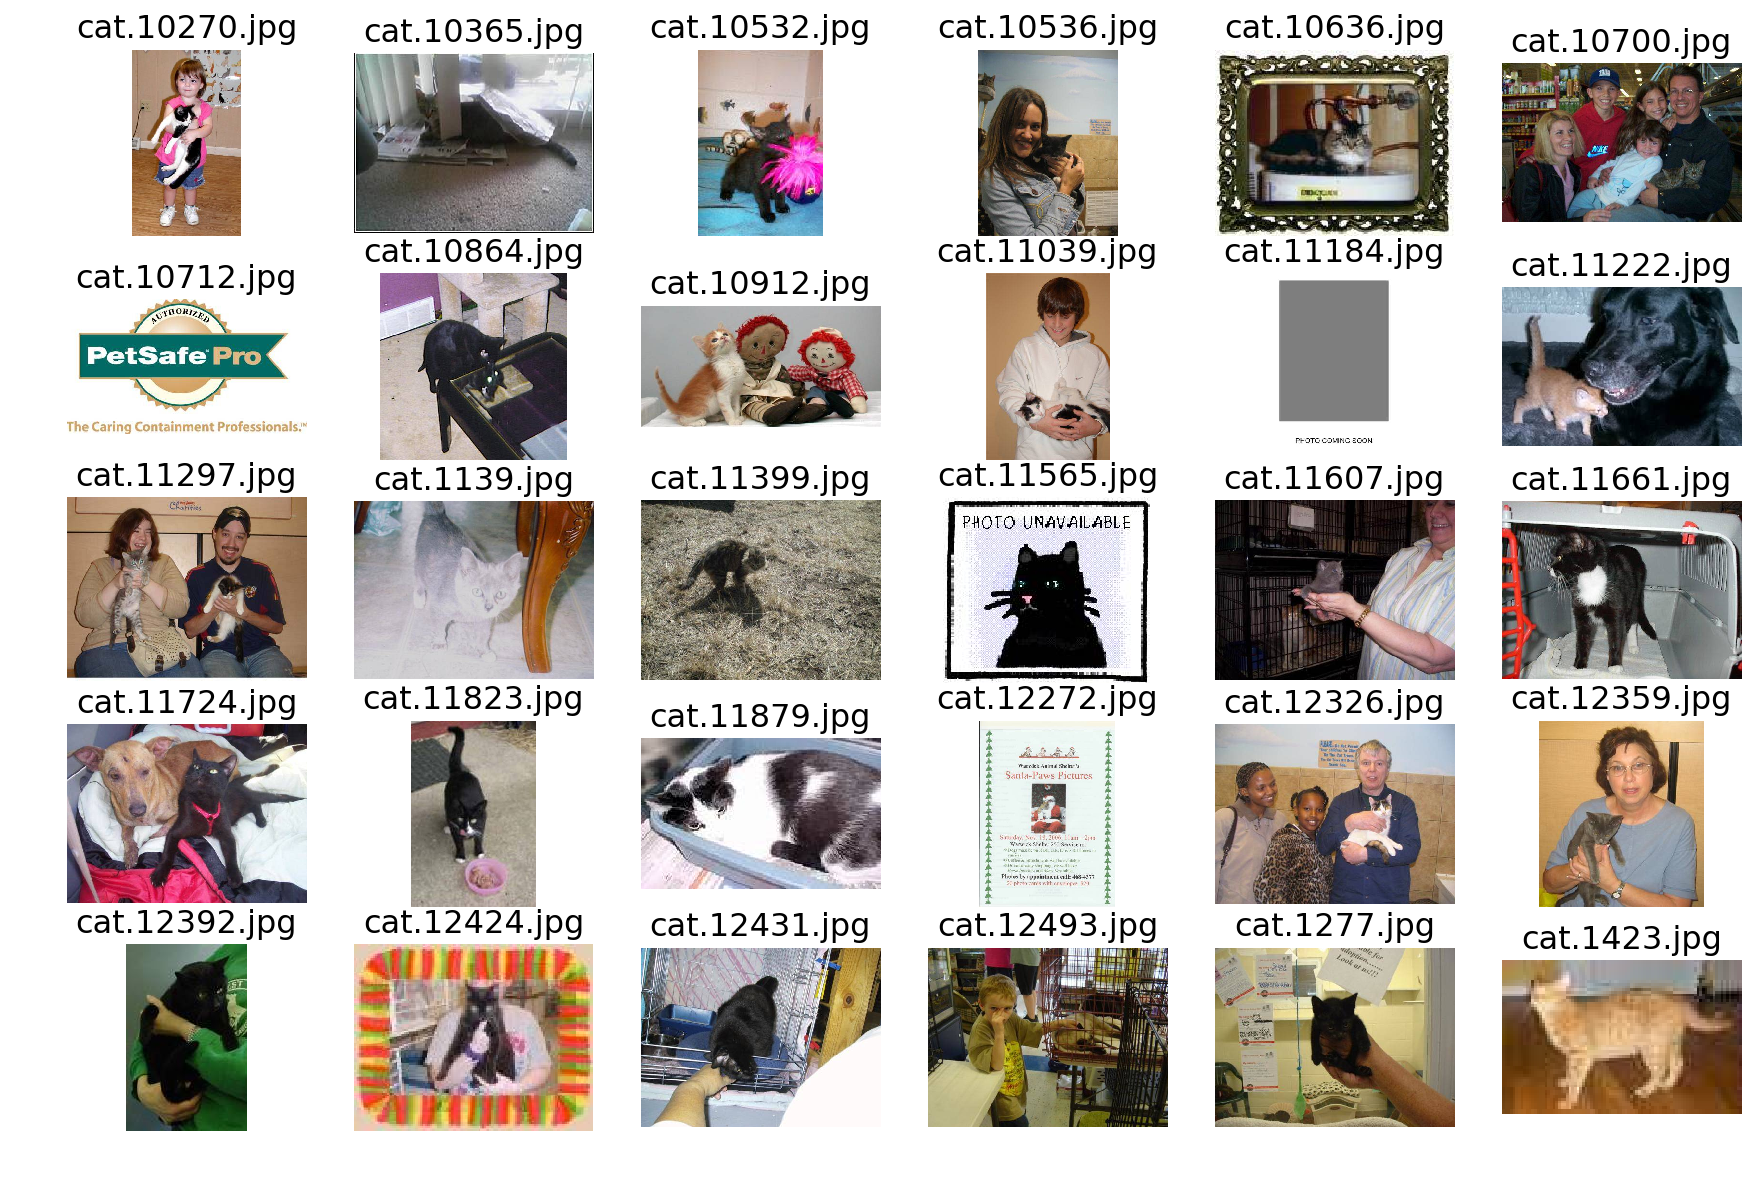

In [14]:
numeritor = 30

plt.figure(figsize=[15, int(numeritor/6*2.5)], edgecolor='gray')
for i in range(1, 1+numeritor):
    plt.subplot(int(numeritor/6)+1, 6, i)
    tester = mpimg.imread(train_dir+ex_files[name][i-1])
    plt.imshow(tester)
    plt.axis('off')
    plt.title(ex_files[name][i-1], fontdict={'fontsize':16})
plt.savefig('ex_files_{}_top{}_sample.jpg'.format(name, top), bbox_inches = 'tight')
plt.show()

In [ ]:
smpl = [i for i in files if i not in ex_files['resnet50']]
len(files)-len(smpl)

## 用预训练模型为基准模型进行预测

In [ ]:
pred_in = []
for file in tqdm(files['test']):
    idx = file.split('.')[0]
    img = image.load_img(data_dir.format('test')+file, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    labels = decode_predictions(preds, top)[0]
    labs = list(list(zip(*labels))[0])
    lab_check = any([((l in dogs and true_lab == 'dog') or (l in cats and true_lab == 'cat')) for l in labs])
    pred_in.append(labels)